<a href="https://colab.research.google.com/github/Saheiyanda/Sa-heed/blob/main/Planet%3A%20Understanding%20the%20Amazon%20from%20Space%20(using%20TensorFlow3%3A%200.67446%20on%20LB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/planet33.zip' planet33.zip # I stored it as planet33.zip in my Drive
!unzip -q /content/drive/MyDrive/planet33.zip

In [3]:
import numpy as np
import pandas as pd


In [4]:
! pip install kaggle --quiet

In [5]:
! mkdir ~/.kaggle

#kaggle.json ---API from kaggle account

In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download planet-understanding-the-amazon-from-space

  0% 0.00/2.94M [00:00<?, ?B/s]
100% 2.94M/2.94M [00:00<00:00, 175MB/s]


In [8]:
! unzip planet-understanding-the-amazon-from-space   #.zip 

Archive:  planet-understanding-the-amazon-from-space.zip
  inflating: Kaggle-planet-test-tif.torrent  
  inflating: Kaggle-planet-train-tif.torrent  
  inflating: sample_submission_v2.csv/sample_submission_v2.csv  
  inflating: test_v2_file_mapping.csv/test_v2_file_mapping.csv  
  inflating: train_v2.csv/train_v2.csv  


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

%matplotlib inline

In [10]:
sample_df = pd.read_csv('/content/sample_submission_v2.csv/sample_submission_v2.csv')
print(sample_df.shape)
sample_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [11]:
sample_df.shape

(61191, 2)

In [12]:
train_classes = pd.read_csv("/content/train_v2.csv/train_v2.csv")
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [13]:
label_list = []
for tag in train_classes.tags.values:
    labels = tag.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [14]:
for label in label_list:
    train_classes[label]= train_classes['tags'].apply(lambda x:1 if label in x.split(' ') else 0)

train_classes.head(5)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [15]:
#print shape of image
img_number = 15
img = io.imread('/content/planet/planet/train-jpg/train_{}.jpg'.format(img_number))
img.shape

(256, 256, 3)

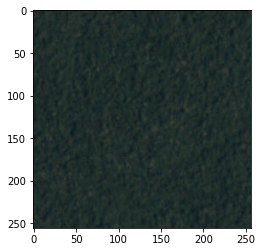

In [16]:
plt.imshow(img)

In [17]:
train_df = pd.read_csv('/content/planet/planet/train_classes.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [18]:
all_tags = [item for sublist in list(train_df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('there are {} non-unique total tags in all training images'.format(len(all_tags)))

there are 116278 non-unique total tags in all training images


In [19]:
#checking for unique tags
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train = train_df.copy()
train['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

#tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
print('There are {} unique tags'.format(len(unique_labels)))
#tags_counted_and_sorted.head()

['road', 'habitation', 'conventional_mine', 'haze', 'cultivation', 'clear', 'bare_ground', 'artisinal_mine', 'selective_logging', 'blooming', 'blow_down', 'slash_burn', 'partly_cloudy', 'water', 'cloudy', 'agriculture', 'primary']
There are 17 unique tags


In [20]:
assert len(train['image_name'].unique()) == train.shape[0]
#one hot encoding labels in the 'train_df'
for tag in unique_labels:
    train[tag] = train['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
#print head
train['image_name'] = train['image_name'].apply(lambda x: '{}.jpg'.format(x))
train.head()

,image_name,tags,road,habitation,conventional_mine,haze,cultivation,clear,bare_ground,artisinal_mine,selective_logging,blooming,blow_down,slash_burn,partly_cloudy,water,cloudy,agriculture,primary
0,train_0.jpg,haze primary,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,train_4.jpg,agriculture clear habitation primary road,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1


In [22]:
y_col = list(train.columns[2:])

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train,
        directory='/content/planet/planet/train-jpg', x_col='image_name', y_col=y_col,
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [23]:
from glob import glob
image_paths = sorted(glob('/content/planet/planet/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

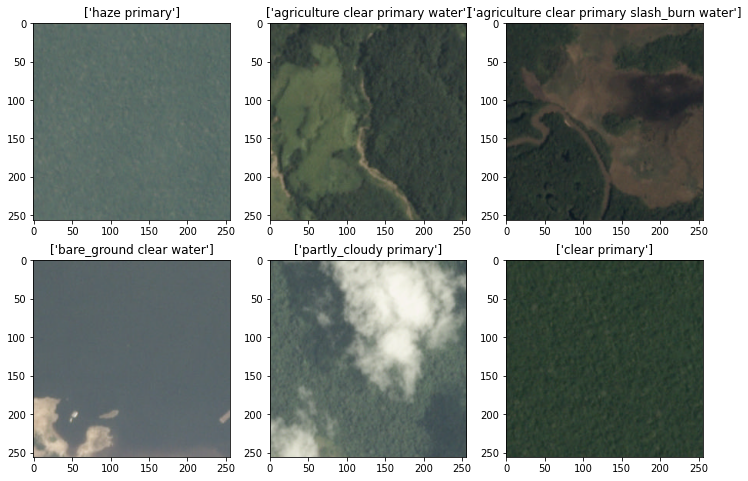

In [24]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(train_df[train_df.image_name == image_names[i]].tags.values))

In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

n_samples = 5000
rescaled_dim = 20

In [26]:
train_df['split_tags'] = train_df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(train_df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread('/content/planet/planet/train-jpg/{}.jpg'.format(name)),
                                    (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) 
                         for name in train_df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

(5000, 1600) (5000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

clf = OneVsRestClassifier(LogisticRegression(max_iter = 2000, C=10, penalty='l2'))
clf.fit(X_train, y_train)   
score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [29]:
print('Mean F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Mean F2 test score 0.6994940522556776
F2 test scores per tag:


[('primary', 0.9671179883945841),
 ('clear', 0.8809590186785614),
 ('cloudy', 0.4868913857677902),
 ('agriculture', 0.39393939393939387),
 ('road', 0.3074245939675173),
 ('artisinal_mine', 0.17857142857142855),
 ('partly_cloudy', 0.1764705882352941),
 ('water', 0.1763046544428773),
 ('habitation', 0.1711491442542787),
 ('cultivation', 0.06265664160401002),
 ('bare_ground', 0.05494505494505496),
 ('haze', 0.019305019305019305),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('selective_logging', 0.0)]

In [30]:
samples= 40669
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('/content/planet/planet/test-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample_df.head(samples)['image_name'].values]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

(40669, 1600)

In [31]:
y_sub = clf.predict(X_sub)
all_test_tags = []
for index in range(y_sub.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))
all_test_tags[0:20]

['clear primary',
 'clear primary',
 'clear habitation primary road water',
 'clear primary',
 'partly_cloudy primary',
 'clear primary',
 'primary',
 'clear habitation road',
 'clear primary',
 'primary',
 'partly_cloudy primary',
 'agriculture clear primary water',
 'cloudy partly_cloudy',
 'clear primary',
 'clear primary',
 'clear primary',
 'clear primary water',
 'agriculture clear primary',
 'clear primary',
 'clear primary']

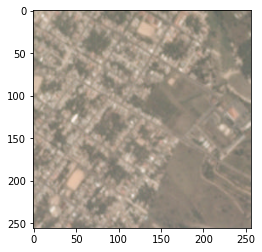

In [32]:
test_images = [plt.imread('/content/planet/planet/test-jpg/{}.jpg'.format(name)) 
               for name in sample_df.head(20)['image_name'].values]
plt.imshow(test_images[7])

In [33]:
sample_df.head(samples)['tags'] = all_test_tags
sample_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear habitation primary road water
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [35]:
sample_df.to_csv("saheed_sub_amazon.csv", index = False)

In [34]:
sample_df.shape

(61191, 2)